In [1]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import os
from sklearn.utils import class_weight

In [2]:
train_dir='/kaggle/input/duth-cv-2019-2020-hw-4/vehicles/train'
val_dir='/kaggle/input/duth-cv-2019-2020-hw-4/vehicles/val'
test_dir='/kaggle/input/duth-cv-2019-2020-hw-4/vehicles/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=30,zoom_range = 0.25,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
val_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

def create_train_gen(bs=100):
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=bs,
        class_mode='categorical',
        shuffle=True)
    return train_generator

def create_weights(train_generator):
    class_weights = class_weight.compute_class_weight(
                   'balanced',
                    np.unique(train_generator.classes), 
                    train_generator.classes)
    return class_weights

def build_model(learning_rate=0.0005,do=0.4):
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(6, 6)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(do),
      tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
    return model

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10,verbose=1,mode='auto',cooldown=1),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001,patience=30,verbose=1,mode='auto')]

def eval_hp(lr,do,bs,epochs=10):
    total_runs = len(do)+len(bs)-1
    counter = 0
    
    stats = []
    best = 0.0
    best_do = 0.0
    for i in do:
        print('Evaluation run: ' + str(counter) + '/' + str(total_runs))
        counter += 1        
        train_generator=create_train_gen()
        class_weights=create_weights(train_generator)
        model=build_model(learning_rate=lr,do=i)
        history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    class_weight=class_weights)
        if (history.history['accuracy'][-1]>best):
            best = history.history['accuracy'][-1]
            best_do = i
        stats.append('lr: '+str(lr)+' do: '+str(i)+' bs: 86 | Acc: '+str(history.history['accuracy'][-1])+' Loss: '+str(history.history['loss'][-1])+'Val_acc:'+str(history.history['val_accuracy'][-1])+'Val_loss'+str(history.history['val_loss'][-1]))
    best = 0.0
    best_bs = 86
    for i in bs:
        print('Evaluation run: ' + str(counter) + '/' + str(total_runs))
        counter += 1        
        train_generator=create_train_gen(bs=i)
        class_weights=create_weights(train_generator)
        model=build_model(learning_rate=lr,do=best_do)
        history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    class_weight=class_weights)
        if (history.history['accuracy'][-1]>best):
            best = history.history['accuracy'][-1]
            best_bs = i
        stats.append('lr: '+str(lr)+' do: '+str(best_do)+' bs: '+str(i)+' | Acc: '+str(history.history['accuracy'][-1])+' Loss: '+str(history.history['loss'][-1])+' Val_acc: '+str(history.history['val_accuracy'][-1])+' Val_loss '+str(history.history['val_loss'][-1]))

    return stats

Found 311 images belonging to 6 classes.


In [3]:
"""
lr = 0.0005
do = [0.0,0.1,0.2,0.3,0.4,0.5]
bs = [20,40,60,80,100,150,200,350,500]
epochs = 10

evaluation = eval_hp(lr,do,bs,epochs)
for i in evaluation:
    print(i)
"""

'\nlr = 0.0005\ndo = [0.0,0.1,0.2,0.3,0.4,0.5]\nbs = [20,40,60,80,100,150,200,350,500]\nepochs = 10\n\nevaluation = eval_hp(lr,do,bs,epochs)\nfor i in evaluation:\n    print(i)\n'

In [4]:
train_generator = create_train_gen(20)
class_weights = create_weights(train_generator)
model = build_model(0.0005,0.1)

history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=300,
                    verbose=1,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    callbacks=callbacks,
                    class_weight=class_weights)

Found 2494 images belonging to 6 classes.
Train for 124 steps, validate for 3 steps
Epoch 1/300
124/124 [==============================] - 35s 286ms/step - loss: 1.5548 - accuracy: 0.3581 - val_loss: 1.3941 - val_accuracy: 0.4433
Epoch 2/300
124/124 [==============================] - 25s 204ms/step - loss: 1.3332 - accuracy: 0.4745 - val_loss: 1.3309 - val_accuracy: 0.4567
Epoch 3/300
124/124 [==============================] - 26s 207ms/step - loss: 1.2522 - accuracy: 0.5121 - val_loss: 1.1308 - val_accuracy: 0.5733
Epoch 4/300
124/124 [==============================] - 26s 207ms/step - loss: 1.1742 - accuracy: 0.5404 - val_loss: 1.1578 - val_accuracy: 0.5800
Epoch 5/300
124/124 [==============================] - 25s 204ms/step - loss: 1.1330 - accuracy: 0.5582 - val_loss: 1.0641 - val_accuracy: 0.5833
Epoch 6/300
124/124 [==============================] - 26s 211ms/step - loss: 1.0944 - accuracy: 0.5715 - val_loss: 1.0078 - val_accuracy: 0.6133
Epoch 7/300
124/124 [===================

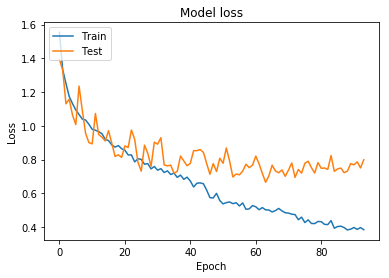

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
model.save('/kaggle/working/m_D_ii.h5')

In [7]:
results = []
test_images = os.listdir(test_dir)
for imgs in test_images:
    path = test_dir + "/" + imgs
    image = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150), grayscale=False, interpolation='nearest')
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
        
    classes_pred = model.predict(image)
    results.append(np.argmax(classes_pred))

In [8]:
import pandas as pd

df = pd.DataFrame(list(zip(test_images, results)), columns =['Id', 'Category'])
df.to_csv('/kaggle/working/data.csv', index=False)
df.head(60)

,Id,Category
0,73902476_ee906db366.jpg,4
1,2672690969_8ac45f25f6.jpg,4
2,2454464852_93202af2ca.jpg,2
3,2426956295_a2b2b43d6f.jpg,2
4,508906244_31ca5d5377.jpg,5
5,437594911_18a1e28294.jpg,3
6,2487329640_b0fbb617a2.jpg,2
7,2722647706_db9b2c8d27.jpg,5
8,443748511_210ce93e3d.jpg,3
9,396525141_fdb672d95e.jpg,0
